
### Multi‑Agent Orchestration DEMO (LangGraph + CPC + Causal Inference)

本ノートブックは，以下を**すべて**含む最小実装のデモです。

- **ダミーデータ生成**（X/YouTube/TikTok/新聞/TV）
- **ソース別専門家エージェント**（LangGraph の *Network* ノードとして定義）
- **Supervisor（中央調停）**＋**Network（横連携）**パターンによる **Multi‑Agent Workflow**
- **CPC（Collective Predictive Coding）層**による共有ナラティブ語彙 $w$ の学習（温度 $\lambda$ による **soft/hard 割当**切替）
- **因果推論層**：簡易 Hawkes/Granger 風の解析（相互相関＋遅延回帰）と**反事実**シミュレーション
- **説明生成**（自然言語要約）と **可視化**（時系列・因果グラフ）

> **注**：このデモは**フレームワーク部分を忠実に実装**することを目的とし，統計推定は極小規模・簡易版です。


In [1]:

# --- 0) 環境セットアップ -------------------------------------------------------
# ※ ローカル実行時に必要な依存をインストールします。
#    （本デモは CPU で数秒〜数十秒程度を想定）
# %pip -q install langgraph langchain langchain-core pydantic networkx numpy pandas matplotlib statsmodels


In [2]:

# --- 1) インポート ------------------------------------------------------------
from __future__ import annotations

from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Any, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from pydantic import BaseModel, Field
import math
import itertools
import json

# LangGraph
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

# 乱数シード固定（再現性）
np.random.seed(42)

In [3]:

# --- 2) ダミーデータ生成 ------------------------------------------------------
# 5つの媒体（X/YT/TK/Press/TV）で「3つのナラティブ（support, critic, neutral）」が
# 10日間（1h刻み）で変化する簡単なシナリオを生成。
# 例）TikTok の 'support' が Day 3 にバズ → 18h 後に X の 'support' と 'critic' が増加

def make_time_index(days=10, freq='1H'):
    return pd.date_range("2025-01-01", periods=24*days, freq=freq)

T = make_time_index(days=10)
n = len(T)

narratives = ["support", "critic", "neutral"]
sources = ["X", "YouTube", "TikTok", "Press", "TV"]

def base_series(level=10, noise=3.0):
    x = level + np.random.randn(n)*noise
    x[x<0] = 0
    return x

# 1) ベースラインを用意
data = {}
for s in sources:
    df = pd.DataFrame(index=T)
    for z in narratives:
        df[z] = base_series(level=8 if z!="neutral" else 12)
    data[s] = df

# 2) 仕掛け：TikTok 'support' を Day3 の中央でバズさせる（ガウス峰）
def add_bump(series, center_idx, height=40, width=6):
    x = np.arange(len(series))
    bump = height*np.exp(-0.5*((x-center_idx)/width)**2)
    return series + bump

center_tk = 24*3 + 12  # Day 3, 12:00
data["TikTok"]["support"] = add_bump(data["TikTok"]["support"].values, center_tk, height=60, width=8)

# 3) 伝播：X では +18h 後に 'support' と 'critic' が増加（左右対称で大小差）
lag_x = 18
for z, h in [("support", 30), ("critic", 20)]:
    data["X"][z] = add_bump(data["X"][z].values, center_tk+lag_x, height=h, width=10)

# 4) Press/TV/YouTube にも弱い波及を作る（Press はやや遅く，TV はさらに遅い）
for s, lg, h in [("YouTube", 10, 15), ("Press", 24, 12), ("TV", 30, 10)]:
    data[s]["support"] = add_bump(data[s]["support"].values, center_tk+lg, height=h, width=10)

# 確認表示
for s in sources:
    display(data[s].head())


/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_21649/2339592934.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  return pd.date_range("2025-01-01", periods=24*days, freq=freq)


,support,critic,neutral
2025-01-01 00:00:00,9.490142,5.622438,11.616247
2025-01-01 01:00:00,7.585207,7.655791,9.133379
2025-01-01 02:00:00,9.943066,9.514962,7.180661
2025-01-01 03:00:00,12.569090,10.597266,12.610391
2025-01-01 04:00:00,7.297540,4.399111,9.730948


,support,critic,neutral
2025-01-01 00:00:00,8.923405,9.928168,12.375674
2025-01-01 01:00:00,2.869495,11.987458,10.711783
2025-01-01 02:00:00,3.955444,8.589564,12.366893
2025-01-01 03:00:00,10.229792,10.127011,13.629894
2025-01-01 04:00:00,8.512596,7.730793,12.146580


,support,critic,neutral
2025-01-01 00:00:00,9.988644,9.211190,6.062101
2025-01-01 01:00:00,11.520422,7.927413,14.243731
2025-01-01 02:00:00,8.543065,5.288894,8.781771
2025-01-01 03:00:00,4.109504,8.973078,12.717741
2025-01-01 04:00:00,9.199064,4.462881,18.222248


,support,critic,neutral
2025-01-01 00:00:00,4.665626,5.834787,17.427919
2025-01-01 01:00:00,8.739514,8.530463,11.345862
2025-01-01 02:00:00,9.494665,6.359960,9.457098
2025-01-01 03:00:00,11.420447,7.185035,10.043733
2025-01-01 04:00:00,12.741622,13.020356,8.731101


,support,critic,neutral
2025-01-01 00:00:00,1.285306e+00,6.549316,8.540003
2025-01-01 01:00:00,1.637900e+00,6.163499,6.937967
2025-01-01 02:00:00,6.179404e+00,9.473623,6.618323
2025-01-01 03:00:00,9.373060e+00,6.925912,7.933657
2025-01-01 04:00:00,5.311092e-26,7.581808,9.872937


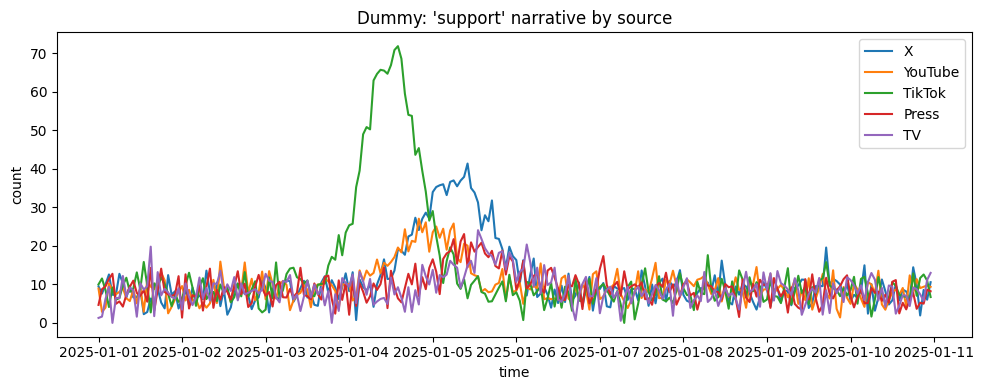

In [4]:

# --- 3) データ可視化（各媒体の 'support'）------------------------------------
plt.figure(figsize=(10,4))
for s in sources:
    plt.plot(data[s].index, data[s]["support"], label=s)
plt.legend()
plt.title("Dummy: 'support' narrative by source")
plt.xlabel("time")
plt.ylabel("count")
plt.tight_layout()
plt.show()


In [5]:
# --- 4) 状態定義 & エージェント（ソース別専門家）-------------------------------
# LangGraph で共有する State（最小）

import pydantic as _pyd
from pydantic import BaseModel, Field
from typing import Dict, List, Any
import pandas as pd
import numpy as np

# Pydantic のメジャー版を判定
_PYD_V2 = str(getattr(_pyd, "__version__", "2")).split(".")[0] == "2"

class NarrativeState(BaseModel):
    # v2: 任意型(DataFrame など)を許可（※「Config」との同時使用はNG）
    if _PYD_V2:
        # ConfigDict を使わず dict でもOK（依存を減らす）
        model_config = {"arbitrary_types_allowed": True}
    else:
        # v1: 従来の Config クラスで許可
        class Config:
            arbitrary_types_allowed = True

    events: Dict[str, pd.DataFrame] = Field(default_factory=dict)         # 各ソースの時系列（support/critic/neutral）
    Z: Dict[str, pd.DataFrame] = Field(default_factory=dict)              # 各ソースの内部表象 z_k(t) （確率分布）
    W: Dict[str, Any] = Field(default_factory=dict)                       # CPC の共有語彙・割当など
    Hypotheses: Dict[str, Any] = Field(default_factory=dict)              # 因果仮説（グラフなど）
    Reports: List[str] = Field(default_factory=list)                      # 説明文
    Phase: str = "start"                                                  # Supervisor 用フェーズ
    Log: List[str] = Field(default_factory=list)                          # ログ

# 4.1 エキスパート：z_k(t) を推定（softmax 正規化→ナラティブ分布）
def softmax(a, axis=1, temp=1.0):
    a = a / max(temp, 1e-6)
    a = a - np.max(a, axis=axis, keepdims=True)
    ea = np.exp(a)
    return ea / np.sum(ea, axis=axis, keepdims=True)

def estimate_z(df: pd.DataFrame, temp=1.0) -> pd.DataFrame:
    # 各時刻で 3成分（support/critic/neutral）を確率に正規化
    X = df[narratives].values
    Z = softmax(X, axis=1, temp=temp)
    zdf = pd.DataFrame(Z, index=df.index, columns=narratives)
    return zdf

def expert_agent(source_name: str, state: NarrativeState) -> NarrativeState:
    df = state.events[source_name]
    zdf = estimate_z(df, temp=0.5)
    state.Z[source_name] = zdf
    state.Log.append(f"[{source_name}Expert] z_k estimated.")
    return state

# 横連携（Network）：エージェント間が代表時刻のピークを共有し合う簡易処理
def peer_share_peaks(state: NarrativeState) -> NarrativeState:
    peaks = {}
    for s, zdf in state.Z.items():
        # 'support' のピーク時刻を抽出
        t_peak = zdf['support'].idxmax()
        peaks[s] = t_peak
    state.W.setdefault("peer_peaks", peaks)
    state.Log.append(f"[Network] peaks shared among experts: {peaks}")
    return state

In [6]:

# --- 5) CPC 層：共有ナラティブ語彙 w の学習（数値安定化） ----------------------
import pydantic as _pyd
from pydantic import BaseModel
import numpy as np
import pandas as pd
_PYD_V2 = str(getattr(_pyd, "__version__", "2")).split(".")[0] == "2"

EPS = 1e-8
EXP_CLIP = 700.0  # np.exp の安全圏

class Codebook(BaseModel):
    if _PYD_V2:
        model_config = {"arbitrary_types_allowed": True}
    else:
        class Config:
            arbitrary_types_allowed = True

    centers: np.ndarray        # (K, D)
    priors:  np.ndarray        # (K,)
    lambda_: float = 1.0

def _row_softmax_stable(score: np.ndarray) -> np.ndarray:
    """各行 softmax（NaN/Inf を受けても安定にして返す）"""
    # 非有限を極小値に落とす
    score = np.where(np.isfinite(score), score, -1e15)
    # 行ごとに最大を引いて exp 安定化
    m = np.max(score, axis=1, keepdims=True)
    score = score - m
    score = np.clip(score, -EXP_CLIP, 0.0)  # 最大は 0（exp(0)=1）
    q = np.exp(score)
    s = q.sum(axis=1, keepdims=True)

    # 全ゼロ/NaN 行は一様にフォールバック
    bad = (~np.isfinite(s)) | (s <= EPS)
    if np.any(bad):
        q[bad[:, 0], :] = 1.0
        s = q.sum(axis=1, keepdims=True)

    q = q / s
    return q

def fit_codebook(z_list, K=3, lambda_=1.0, iters=10, seed=0) -> Codebook:
    rng = np.random.default_rng(seed)
    Z = np.vstack([z.values for z in z_list]).astype(np.float64)  # (N,D)
    N, D = Z.shape

    # 初期中心はランダムサンプル
    centers = Z[rng.choice(N, size=K, replace=False)]
    priors  = np.ones(K, dtype=np.float64) / K

    # 分散はデータスケールから自動（過小だと数値爆発しやすい）
    var = max(0.1 * float(np.var(Z)), 1e-3)

    def log_p_z_given_w(Z, c):
        # N(Z | center, var I) の対数尤度
        diff = Z[:, None, :] - c[None, :, :]         # (N,K,D)
        ll = -0.5 * np.sum(diff * diff, axis=2) / var - 0.5 * D * np.log(2*np.pi*var)
        return ll

    for _ in range(iters):
        ll = log_p_z_given_w(Z, centers)            # (N,K)
        logpri = np.log(np.clip(priors, EPS, None))[None, :]  # (1,K)

        # q*(w|z) ∝ p(w) * exp((1/λ) * ll)
        score = logpri + (1.0 / max(lambda_, EPS)) * ll
        q = _row_softmax_stable(score)              # (N,K)

        # E-step -> M-step（分母0回避、NaN防止）
        Nk = np.clip(q.sum(axis=0), EPS, None)      # (K,)
        centers = (q.T @ Z) / Nk[:, None]
        priors = Nk / np.sum(Nk)
        priors = np.clip(priors, EPS, None)
        priors = priors / np.sum(priors)

        # まれに NaN/Inf が残る場合の安全弁
        if not np.all(np.isfinite(centers)):
            centers = np.nan_to_num(centers, nan=0.0, posinf=0.0, neginf=0.0)

    return Codebook(centers=centers, priors=priors, lambda_=lambda_)

def assign_to_codebook(zdf: pd.DataFrame, codebook: Codebook, hard=False) -> pd.DataFrame:
    Z = zdf.values.astype(np.float64)
    c = codebook.centers.astype(np.float64)
    pri = np.clip(codebook.priors.astype(np.float64), EPS, None)

    # 対数尤度
    diff = Z[:, None, :] - c[None, :, :]
    ll   = -0.5 * np.sum(diff * diff, axis=2) / max(0.1 * float(np.var(Z)), 1e-3)
    score = np.log(pri)[None, :] + (1.0 / max(codebook.lambda_, EPS)) * ll
    q = _row_softmax_stable(score)

    if hard or codebook.lambda_ < 1e-3:
        idx = np.argmax(q, axis=1)
        hard_q = np.zeros_like(q); hard_q[np.arange(len(idx)), idx] = 1.0
        q = hard_q

    return pd.DataFrame(q, index=zdf.index, columns=[f"w{k}" for k in range(q.shape[1])])

def codebook_weaver(state, K=3, lambda_=0.7):
    z_list = list(state.Z.values())
    cb = fit_codebook(z_list, K=K, lambda_=lambda_, iters=12, seed=42)
    state.W["codebook"] = cb

    soft_assignments, hard_assignments = {}, {}
    for s, zdf in state.Z.items():
        soft_assignments[s] = assign_to_codebook(zdf, cb, hard=False)
        hard_assignments[s] = assign_to_codebook(zdf, cb, hard=True)
    state.W["assign_soft"] = soft_assignments
    state.W["assign_hard"] = hard_assignments

    state.Log.append(f"[CPC] codebook learned (K={K}, lambda={lambda_}).")
    return state

# Network 的相互審査：MH Naming Game 風（数値安定化）
def mh_language_game(state, rounds=3):
    cb: Codebook = state.W["codebook"]
    centers = cb.centers.copy()
    pri = cb.priors.copy()

    srcs = list(state.Z.keys())
    for r in range(rounds):
        for proposer in srcs:
            zdf = state.Z[proposer]
            hard = state.W["assign_hard"][proposer].values
            maj = int(np.argmax(hard.sum(axis=0)))
            proposal = centers[maj] + np.random.randn(*centers[maj].shape) * 0.01

            # “採択前後の対数尤度合計差”で MH 受理判定（オーバーフロー防止）
            def total_ll(c):
                ll = 0.0
                for _, z in state.Z.items():
                    diff = z.values - c[None, :]
                    ll += -0.5 * float(np.sum(diff * diff)) / max(0.1 * float(np.var(z.values)), 1e-3)
                return ll

            delta = total_ll(proposal) - total_ll(centers[maj])
            accept = True if delta >= 0 else (np.random.rand() < np.exp(max(-50.0, delta)))
            if accept:
                centers[maj] = proposal
        state.Log.append(f"[MHNG] round {r+1} completed.")

    cb.centers = centers
    state.W["codebook"] = cb
    state.Log.append("[Network] MH naming game refinement done.")
    return state

In [7]:

# --- 6) 因果推論層（簡易版）----------------------------------------------------
# 目的：媒体間の伝播（誰→誰, どのラグ）を推定し，簡易的な反事実も生成。
# 手法：
#  - 相互相関により候補ラグを抽出
#  - ラグ付き線形回帰（OLS）で効果量を評価（p値は簡易）
#  - ネットワーク（DiGraph）に重み（effect）とラグ（lag）を格納
#  - 反事実：最強エッジをゼロ介入して予測差分を出す

from numpy.linalg import lstsq

def best_lag(x, y, max_lag=36):
    # x->y の遅延（x 先行）を正のラグとして定義
    lags = range(0, max_lag+1)
    best = (0, -np.inf)
    for L in lags:
        xs = x[:-L] if L>0 else x
        ys = y[L:] if L>0 else y
        if len(xs)<5: break
        c = np.corrcoef(xs, ys)[0,1]
        if np.isnan(c): c=0.0
        if c>best[1]: best=(L,c)
    return best  # (lag, corr)

def lagged_regression(X, y, lags):
    """
    X: shape (T, N), y: shape (T,)
    lags[i]: 予測対象 y(t) に対し X[:, i] の (t - lags[i]) を使う
    アライン後のサンプル長は (T - Lmax) に統一する
    """
    T, N = X.shape
    Lmax = max(lags) if lags else 0
    if T - Lmax <= 2:
        raise ValueError("Not enough samples after lag alignment.")

    # y を Lmax だけ先頭カット
    yy = y[Lmax:]

    # 各説明変数を「t-L_i」を拾って (T-Lmax, N) 行列に整列
    rows = []
    for t in range(Lmax, T):
        rows.append([X[t - L_i, i] for i, L_i in enumerate(lags)])
    Xd = np.asarray(rows)  # (T-Lmax, N)

    # 切片項を追加
    Xd = np.hstack([np.ones((Xd.shape[0], 1)), Xd])

    beta, _, _, _ = lstsq(Xd, yy, rcond=None)
    return beta, Xd, yy

def causal_cartographer(state: NarrativeState, target_narr="support") -> NarrativeState:
    # 各ソースの target_narr を使って因果エッジを推定
    series = {s: state.events[s][target_narr].values.astype(float) for s in sources}
    G = nx.DiGraph()
    for s in sources: G.add_node(s)

    # まず pairwise に最良ラグを探索
    best_lags = {}
    for a,b in itertools.permutations(sources,2):
        lag,c = best_lag(series[a], series[b], max_lag=36)
        best_lags[(a,b)] = (lag,c)

    # その後，y=b に対して X=他ノード（a）のラグ付き回帰を実行
    for b in sources:
        preds=[]; lgs=[]
        Xcols=[]
        for a in sources:
            if a==b: continue
            lag,_ = best_lags[(a,b)]
            Xcols.append(series[a])
            lgs.append(lag)
            preds.append(a)
        X = np.vstack(Xcols).T
        y = series[b]
        beta,Xd,yy = lagged_regression(X, y, lgs)
        # 切片 beta[0]，各説明変数の係数 beta[1:]
        for i,a in enumerate(preds):
            eff = beta[1+i]
            lag = lgs[i]
            if abs(eff)>0.05:   # 閾値
                G.add_edge(a,b, effect=float(eff), lag=int(lag))

    state.Hypotheses["causal_graph"] = G
    state.Hypotheses["best_lags"] = best_lags
    state.Log.append("[Causal] graph estimated.")
    return state

def counterfactual_sim(state: NarrativeState, source="TikTok", sink="X", target_narr="support"):
    # sink(t) ~ a0 + a1 * source(t-lag) + ... の近似回帰を用い，source をゼロ介入した場合の差分を推定
    series_s = state.events[source][target_narr].values.astype(float)
    series_t = state.events[sink][target_narr].values.astype(float)
    lag,_ = state.Hypotheses["best_lags"][(source, sink)]
    # 単一説明変数回帰
    xs = series_s[:-lag] if lag>0 else series_s
    yt = series_t[lag:] if lag>0 else series_t
    Xd = np.vstack([np.ones(len(xs)), xs]).T
    beta,_,_,_ = lstsq(Xd, yt, rcond=None)
    yhat = Xd @ beta
    # 介入：source=0
    X0 = np.vstack([np.ones(len(xs)), np.zeros_like(xs)]).T
    ycf = X0 @ beta
    # 効果量
    delta = (yhat - ycf).mean()
    return lag, beta, delta, yhat, ycf, len(xs)

def causal_plots(state: NarrativeState, target_narr="support"):
    G = state.Hypotheses["causal_graph"]
    plt.figure(figsize=(6,4))
    pos = nx.circular_layout(G)
    labels = { (u,v): f"{d['effect']:.2f}@{d['lag']}h" for u,v,d in G.edges(data=True) }
    nx.draw(G, pos, with_labels=True, node_size=1500)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    plt.title(f"Causal graph ({target_narr})")
    plt.tight_layout()
    plt.show()


In [8]:

# --- 7) LangGraph 構築（Supervisor + Network）---------------------------------
# Supervisor がフェーズを見ながらノードをルーティング。
# Network は Experts -> PeerShare -> CPC(MHNG) の横連携ループを表現。

from langgraph.checkpoint.serde.jsonplus import JsonPlusSerializer

def set_phase(state: NarrativeState, phase: str) -> NarrativeState:
    state.Phase = phase
    state.Log.append(f"[Supervisor] phase -> {phase}")
    return state

# --- ノード定義 ---
def ingest_node(state: NarrativeState) -> NarrativeState:
    state.events = data
    state = set_phase(state, "experts")
    return state

def x_expert_node(state: NarrativeState) -> NarrativeState:
    return expert_agent("X", state)

def yt_expert_node(state: NarrativeState) -> NarrativeState:
    return expert_agent("YouTube", state)

def tk_expert_node(state: NarrativeState) -> NarrativeState:
    return expert_agent("TikTok", state)

def press_expert_node(state: NarrativeState) -> NarrativeState:
    return expert_agent("Press", state)

def tv_expert_node(state: NarrativeState) -> NarrativeState:
    return expert_agent("TV", state)

def peer_network_node(state: NarrativeState) -> NarrativeState:
    return peer_share_peaks(state)

def cpc_node(state: NarrativeState) -> NarrativeState:
    state = codebook_weaver(state, K=3, lambda_=0.7)
    state = mh_language_game(state, rounds=2)
    state = set_phase(state, "causal")
    return state

def causal_node(state: NarrativeState) -> NarrativeState:
    state = causal_cartographer(state, target_narr="support")
    state = set_phase(state, "counterfactual")
    return state

def counterfactual_node(state: NarrativeState) -> NarrativeState:
    lag,beta,delta,yhat,ycf,nobs = counterfactual_sim(state, source="TikTok", sink="X", target_narr="support")
    txt = f"[Counterfactual] If TikTok 'support' were zero, X 'support' would drop by {delta:.2f} on average (lag={lag}h, n={nobs})."
    state.Reports.append(txt)
    state = set_phase(state, "explain")
    return state

def explainer_node(state: NarrativeState) -> NarrativeState:
    # 上位エッジの説明をつくる
    G = state.Hypotheses["causal_graph"]
    edges = sorted(G.edges(data=True), key=lambda e: abs(e[2]["effect"]), reverse=True)[:5]
    lines = ["[NarrativeExplainer] Top causal edges (effect@lag):"]
    for u,v,d in edges:
        lines.append(f"- {u} -> {v}: {d['effect']:.2f}@{d['lag']}h")
    state.Reports += lines
    state = set_phase(state, "done")
    return state

# --- Supervisor: 次ノードの条件分岐 ---
def supervisor_router(state: NarrativeState):
    if state.Phase == "start":
        return "INGEST"
    if state.Phase == "experts":
        # Experts が全て Z を出したら PeerShare へ
        if len(state.Z) < 5:
            # 次に呼ぶエージェントをラウンドロビン
            pending = [s for s in sources if s not in state.Z]
            if pending:
                nxt = pending[0]
                return {"X":"XEXP","YouTube":"YTEXP","TikTok":"TKEXP","Press":"PRESSEXP","TV":"TVEXP"}[nxt]
        return "PEER"
    if state.Phase == "experts_done":
        return "CPC"
    if state.Phase == "causal":
        return "CAUSAL"
    if state.Phase == "counterfactual":
        return "COUNTERFACT"
    if state.Phase == "explain":
        return "EXPLAIN"
    return END

# --- グラフ構築 ---
builder = StateGraph(NarrativeState)

# ノード登録
builder.add_node("INGEST", ingest_node)

builder.add_node("XEXP", x_expert_node)
builder.add_node("YTEXP", yt_expert_node)
builder.add_node("TKEXP", tk_expert_node)
builder.add_node("PRESSEXP", press_expert_node)
builder.add_node("TVEXP", tv_expert_node)

builder.add_node("PEER", peer_network_node)
builder.add_node("CPC", cpc_node)
builder.add_node("CAUSAL", causal_node)
builder.add_node("COUNTERFACT", counterfactual_node)
builder.add_node("EXPLAIN", explainer_node)

# 入口は Supervisor 的にルーティング
builder.set_entry_point("INGEST")

# エッジ（Supervisor ルータの条件で遷移させる）
builder.add_conditional_edges(
    "INGEST",
    lambda s: "XEXP",
    {"XEXP":"XEXP"}
)

# Experts フェーズ： Supervisor 的に 5 エージェントを順に呼ぶ -> Peer
builder.add_conditional_edges(
    "XEXP",
    supervisor_router,
    {"XEXP":"XEXP","YTEXP":"YTEXP","TKEXP":"TKEXP","PRESSEXP":"PRESSEXP","TVEXP":"TVEXP","PEER":"PEER"}
)
builder.add_conditional_edges(
    "YTEXP",
    supervisor_router,
    {"XEXP":"XEXP","YTEXP":"YTEXP","TKEXP":"TKEXP","PRESSEXP":"PRESSEXP","TVEXP":"TVEXP","PEER":"PEER"}
)
builder.add_conditional_edges(
    "TKEXP",
    supervisor_router,
    {"XEXP":"XEXP","YTEXP":"YTEXP","TKEXP":"TKEXP","PRESSEXP":"PRESSEXP","TVEXP":"TVEXP","PEER":"PEER"}
)
builder.add_conditional_edges(
    "PRESSEXP",
    supervisor_router,
    {"XEXP":"XEXP","YTEXP":"YTEXP","TKEXP":"TKEXP","PRESSEXP":"PRESSEXP","TVEXP":"TVEXP","PEER":"PEER"}
)
builder.add_conditional_edges(
    "TVEXP",
    supervisor_router,
    {"XEXP":"XEXP","YTEXP":"YTEXP","TKEXP":"TKEXP","PRESSEXP":"PRESSEXP","TVEXP":"TVEXP","PEER":"PEER"}
)

# Peer -> CPC -> Causal -> Counterfactual -> Explain -> END
builder.add_edge("PEER", "CPC")
builder.add_edge("CPC", "CAUSAL")
builder.add_edge("CAUSAL", "COUNTERFACT")
builder.add_edge("COUNTERFACT", "EXPLAIN")
builder.add_edge("EXPLAIN", END)

# DataFrame など任意型を pickle で保存できるようにする
memory = MemorySaver(serde=JsonPlusSerializer(pickle_fallback=True))
graph = builder.compile(checkpointer=memory)

/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_21649/872181681.py:70: RuntimeWarning: divide by zero encountered in matmul
  centers = (q.T @ Z) / Nk[:, None]
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_21649/872181681.py:70: RuntimeWarning: overflow encountered in matmul
  centers = (q.T @ Z) / Nk[:, None]
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_21649/872181681.py:70: RuntimeWarning: invalid value encountered in matmul
  centers = (q.T @ Z) / Nk[:, None]
/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_21649/2069764953.py:113: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


[Counterfactual] If TikTok 'support' were zero, X 'support' would drop by 6.96 on average (lag=18h, n=222).
[NarrativeExplainer] Top causal edges (effect@lag):
- YouTube -> TikTok: 1.72@0h
- Press -> TikTok: -0.44@0h
- TikTok -> X: 0.39@18h
- Press -> X: 0.28@0h
- TikTok -> YouTube: 0.25@10h

--- LOG (tail) ---
[Network] peaks shared among experts: {'X': Timestamp('2025-01-05 10:00:00'), 'YouTube': Timestamp('2025-01-04 20:00:00'), 'TikTok': Timestamp('2025-01-04 02:00:00'), 'Press': Timestamp('2025-01-05 08:00:00'), 'TV': Timestamp('2025-01-05 13:00:00')}
[CPC] codebook learned (K=3, lambda=0.7).
[MHNG] round 1 completed.
[MHNG] round 2 completed.
[Network] MH naming game refinement done.
[Supervisor] phase -> causal
[Causal] graph estimated.
[Supervisor] phase -> counterfactual
[Supervisor] phase -> explain
[Supervisor] phase -> done


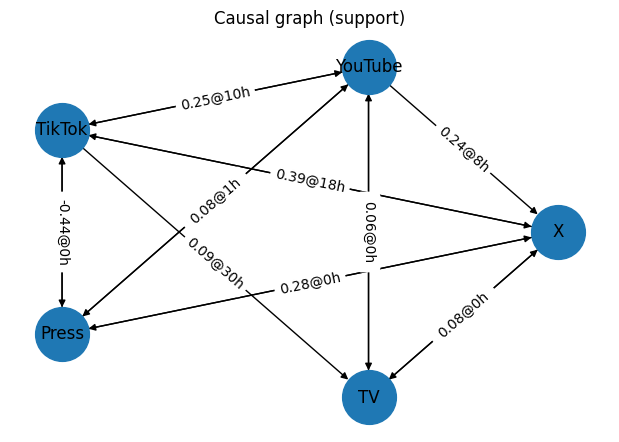

In [9]:

# --- 8) 実行 -----------------------------------------------------------------
init_state = NarrativeState()

# ✅ MemorySaver を使っているので、thread_id を含む config を必ず渡す
cfg = {"configurable": {"thread_id": "cpc-demo-thread"}}

out = graph.invoke(init_state, config=cfg)

# LangGraph は dict を返すことがあるので、Pydantic モデルに復元して扱う
try:
    # Pydantic v2
    result = NarrativeState.model_validate(out) if isinstance(out, dict) else out
except AttributeError:
    # Pydantic v1 後方互換
    result = NarrativeState.parse_obj(out) if isinstance(out, dict) else out

# 出力
print("\n".join(result.Reports[:10]))
print("\n--- LOG (tail) ---")
print("\n".join(result.Log[-10:]))

# 可視化（因果グラフ／TikTok->X 反事実の参考）
causal_plots(result, target_narr="support")

Codebook centers:
 [[0.03248428 0.86852955 0.09898617]
 [0.92381007 0.02741251 0.04877742]
 [0.04403066 0.0667745  0.90832559]]
Priors: [0.13382864 0.24953295 0.6166384 ]


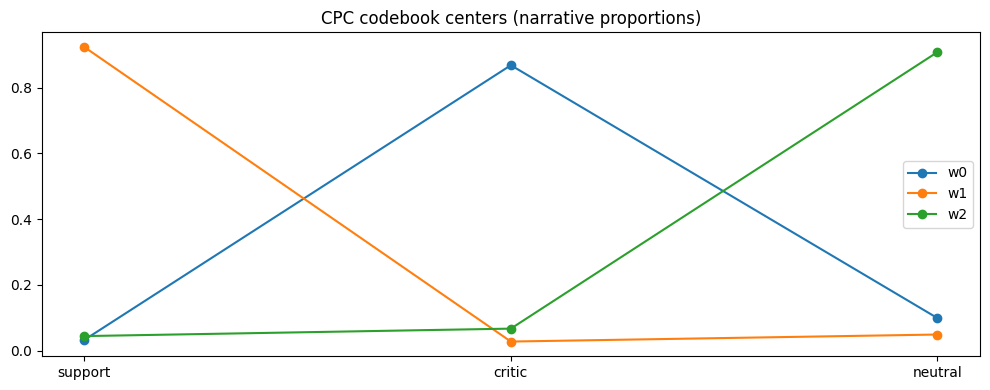

,w0,w1,w2
2025-01-01 00:00:00,2.136312e-18,1.000000e+00,1.076402e-24
2025-01-01 01:00:00,2.673545e-26,5.705776e-29,1.000000e+00
2025-01-01 02:00:00,6.215218e-16,3.282278e-07,9.999997e-01
2025-01-01 03:00:00,2.187339e-26,3.354716e-29,1.000000e+00
2025-01-01 04:00:00,2.040121e-26,3.232554e-29,1.000000e+00


,w0,w1,w2
2025-01-01 00:00:00,0.0,1.0,0.0
2025-01-01 01:00:00,0.0,0.0,1.0
2025-01-01 02:00:00,0.0,0.0,1.0
2025-01-01 03:00:00,0.0,0.0,1.0
2025-01-01 04:00:00,0.0,0.0,1.0


,w0,w1,w2
2025-01-01 00:00:00,2.120076e-27,6.343458e-30,1.000000e+00
2025-01-01 01:00:00,6.638938e-24,7.842000e-27,1.000000e+00
2025-01-01 02:00:00,4.407989e-12,1.000000e+00,3.527332e-22
2025-01-01 03:00:00,1.248680e-13,9.879421e-02,9.012058e-01
2025-01-01 04:00:00,1.389849e-27,2.600167e-30,1.000000e+00


,w0,w1,w2
2025-01-01 00:00:00,0.0,0.0,1.0
2025-01-01 01:00:00,0.0,0.0,1.0
2025-01-01 02:00:00,0.0,1.0,0.0
2025-01-01 03:00:00,0.0,0.0,1.0
2025-01-01 04:00:00,0.0,0.0,1.0


In [10]:

# --- 9) 追加可視化：CPC の割当の様子 ------------------------------------------
cb = result.W["codebook"]
print("Codebook centers:\n", cb.centers)
print("Priors:", cb.priors)

plt.figure(figsize=(10,4))
for k in range(cb.centers.shape[0]):
    plt.plot(narratives, cb.centers[k], marker='o', label=f"w{k}")
plt.legend()
plt.title("CPC codebook centers (narrative proportions)")
plt.tight_layout()
plt.show()

# TikTok/X の soft/hard 割当を少しだけ表示
for s in ["TikTok","X"]:
    display(result.W["assign_soft"][s].head())
    display(result.W["assign_hard"][s].head())



### 10) Add-on 1 — 生成過程の補完 *w → z → o* と指標（NLL / Jensen–Shannon）

- `w`（共有語彙）の**soft 割当** `assign_soft[source]` を用いて $\mathbb{E}[z\mid w] = \sum_m q(w{=}m\mid z)\,c_m$（`c_m` は codebook center）を計算し，
  生成過程 $w\to z$ を**前向き復元**します。
- $z$ を観測 $o$ の確率（3クラス：`support, critic, neutral`）とみなし，**観測カウント**と比較して
  - 負の対数尤度 `NLL(o|z)`
  - Jensen–Shannon 距離 `JS(p_obs || p_pred)`
  を各ソース・時刻で計算します。


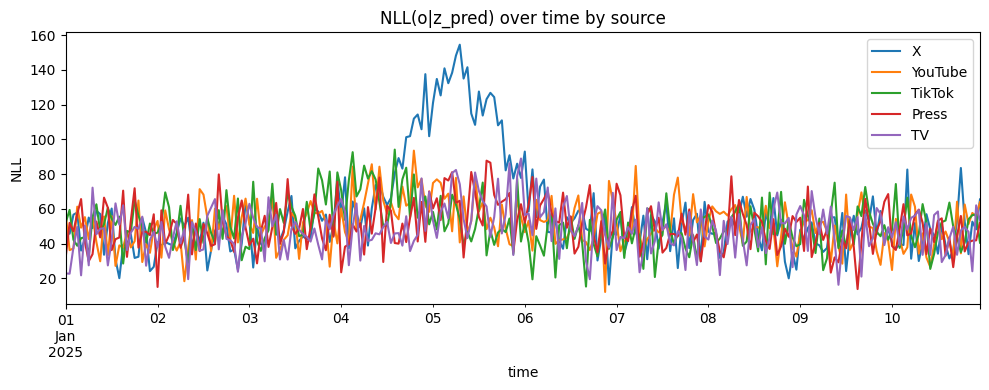

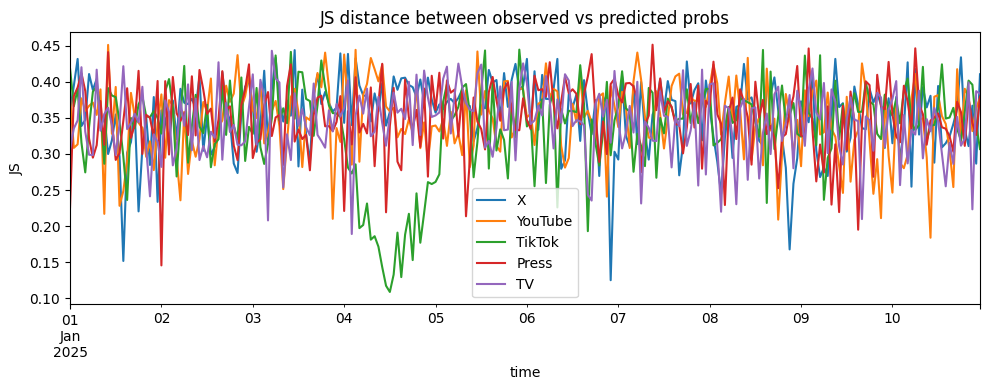

=== Forward metrics summary (lower is better) ===


,NLL_mean,NLL_median,JS_mean,JS_median
source,,,,
Press,50.235228,48.948183,0.350557,0.354543
TV,48.515018,48.598419,0.344759,0.347325
TikTok,51.234433,49.892517,0.335866,0.348806
X,57.790089,51.923553,0.354811,0.364718
YouTube,51.221284,50.437531,0.347887,0.352533


In [11]:

# --- Add-on 1: w->z->o forward simulation and metrics -------------------------
import numpy as np, pandas as pd, math
import matplotlib.pyplot as plt

def _get_attr(obj, key, default=None):
    if hasattr(obj, key):
        return getattr(obj, key)
    if isinstance(obj, dict):
        return obj.get(key, default)
    return default

# Access result and core objects
_res = result  # assume previous cells created 'result'
_events = _get_attr(_res, "events")
_Z = _get_attr(_res, "Z")
_W = _get_attr(_res, "W")
assert _events is not None and _Z is not None and _W is not None, "result.events/Z/W が見つかりません。"

cb = _W["codebook"]
assign_soft = _W.get("assign_soft", {})
sources = list(_events.keys())
narratives = ["support","critic","neutral"]

# Helper: JS divergence for discrete distributions
def js_divergence(p, q, eps=1e-12):
    p = np.asarray(p, dtype=float); q = np.asarray(q, dtype=float)
    p = np.clip(p, eps, 1.0); q = np.clip(q, eps, 1.0)
    p = p / p.sum(); q = q / q.sum()
    m = 0.5*(p+q)
    def _kl(a, b):
        return np.sum(a * (np.log(a) - np.log(b)))
    return math.sqrt(0.5*_kl(p,m) + 0.5*_kl(q,m))

# Helper: NLL of multinomial counts under prob vector p
def nll_counts(counts, p, eps=1e-12):
    p = np.clip(np.asarray(p, float), eps, 1.0)
    p = p / p.sum()
    c = np.asarray(counts, float)
    return -float(np.sum(c * np.log(p)))

# Predict z from soft w, then map to o-prob (=z)
K = cb.centers.shape[0]
centers = np.asarray(cb.centers, float)   # (K, D=3)
pred = {}    # per source: DataFrame of p_pred(t, narrative)
nlls = {}    # per source: Series NLL over time
jss  = {}    # per source: Series JS over time

for s in sources:
    df = _events[s].copy()
    # observed probability over narratives
    obs = df[narratives].astype(float)
    obs_prob = (obs.T / np.clip(obs.sum(axis=1).values, 1e-9, None)).T

    # predicted z from soft assignment over w (if not present, fallback to z)
    if s in assign_soft:
        Q = assign_soft[s].values  # (T,K)
        z_pred = Q @ centers       # (T,3)
        z_pred = np.clip(z_pred, 1e-9, None)
        z_pred = (z_pred.T / z_pred.sum(axis=1)).T
        z_pred_df = pd.DataFrame(z_pred, index=df.index, columns=narratives)
    else:
        # fallback: use inferred z
        z_pred_df = _Z[s][narratives].copy()

    pred[s] = z_pred_df

    # metrics
    nll_series = []
    js_series  = []
    for t in df.index:
        p_obs = obs_prob.loc[t].values
        p_prd = z_pred_df.loc[t].values
        cts   = obs.loc[t].values
        nll_series.append(nll_counts(cts, p_prd))
        js_series.append(js_divergence(p_obs, p_prd))
    nlls[s] = pd.Series(nll_series, index=df.index, name="NLL")
    jss[s]  = pd.Series(js_series, index=df.index, name="JS")

# --- dashboard plots
plt.figure(figsize=(10,4))
for s in sources:
    nlls[s].plot(label=s)
plt.title("NLL(o|z_pred) over time by source")
plt.xlabel("time"); plt.ylabel("NLL")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(10,4))
for s in sources:
    jss[s].plot(label=s)
plt.title("JS distance between observed vs predicted probs")
plt.xlabel("time"); plt.ylabel("JS")
plt.legend(); plt.tight_layout(); plt.show()

# summary table
summary_rows = []
for s in sources:
    summary_rows.append({
        "source": s,
        "NLL_mean": float(nlls[s].mean()),
        "NLL_median": float(nlls[s].median()),
        "JS_mean": float(jss[s].mean()),
        "JS_median": float(jss[s].median())
    })
metrics_summary = pd.DataFrame(summary_rows).set_index("source").sort_index()
print("=== Forward metrics summary (lower is better) ===")
display(metrics_summary)



### 11) Add-on 2 — 媒介効果の分離（**二段推定**）

- 例として **TikTok → Twitter** の `support` 流入を対象に，**総効果（TE）／直接効果（DE）／媒介効果（IE）** を分解します。
- 媒介 $M$ は CPC の共有語彙のうち **`support` 成分が最大の codeword** の soft 割当 $q(w{=}m\mid z)$（TikTok側）とします。
- 手順：
  1. **ラグ探索**（相互相関のピーク）で各パスの遅延を自動選択
  2. **第1段**: $M\_{t} \leftarrow S\_{t-\ell\_1}$（TikTok `support`）
  3. **第2段**: $Y\_{t} \leftarrow S\_{t-\ell\_2} + M\_{t-\ell\_3}$（Twitter `support`）
  4. **TE**: $Y\leftarrow S$ の係数，**IE**: $a\times b$，**DE**: 第2段の $S$ 係数


In [12]:

# --- Add-on 2: Mediation decomposition (two-stage OLS) ------------------------
import numpy as np, pandas as pd
from numpy.linalg import lstsq

def _best_lag(x, y, max_lag=36):
    x = np.asarray(x, float); y = np.asarray(y, float)
    x = (x - x.mean()) / (x.std() + 1e-9)
    y = (y - y.mean()) / (y.std() + 1e-9)
    best = (0, -1e9)
    for lag in range(0, max_lag+1):
        xx = x[:-lag] if lag>0 else x
        yy = y[lag:] if lag>0 else y
        if len(xx) != len(yy) or len(xx) < 8:
            continue
        c = float(np.correlate(xx, yy, mode="valid")[0]) / len(xx)
        if c > best[1]:
            best = (lag, c)
    return best[0]

def _ols(y, X):
    X = np.asarray(X, float); y = np.asarray(y, float).reshape(-1,1)
    Xc = np.column_stack([np.ones(len(X)), X])
    beta, *_ = lstsq(Xc, y, rcond=None)
    yhat = Xc @ beta
    resid = y - yhat
    n,k = Xc.shape
    s2 = float((resid.T @ resid) / max(n-k,1))
    cov = s2 * np.linalg.inv(Xc.T @ Xc)
    se  = np.sqrt(np.diag(cov)).reshape(-1,1)
    return beta.flatten(), se.flatten(), resid.flatten()

def _align_by_lag(src, tgt, lag):
    # src(t-lag) aligned to tgt(t)
    if lag>0:
        return src[:-lag], tgt[lag:]
    else:
        return src, tgt

# choose signals
src_support = _events["TikTok"]["support"].astype(float).values
tgt_support = _events["X"]["support"].astype(float).values

# mediator: soft assignment prob. of the "most-supportive" codeword on TikTok
centers = np.asarray(cb.centers, float)          # (K,3)
support_dim = 0                                  # column index for 'support'
m_idx = int(np.argmax(centers[:, support_dim]))  # codeword index
if "TikTok" in assign_soft:
    mediator_series = assign_soft["TikTok"].iloc[:, m_idx].values
else:
    mediator_series = _Z["TikTok"]["support"].astype(float).values  # fallback

# 1) total effect lag S->Y
lag_sy = _best_lag(src_support, tgt_support, max_lag=36)
S1, Y1 = _align_by_lag(src_support, tgt_support, lag_sy)
b_te, se_te, _ = _ols(Y1, S1.reshape(-1,1))   # [intercept, beta_S]

# 2) path a: S->M
lag_sm = _best_lag(src_support, mediator_series, max_lag=36)
S2, M2 = _align_by_lag(src_support, mediator_series, lag_sm)
b_a, se_a, _ = _ols(M2, S2.reshape(-1,1))     # [intercept, a]

# 3) path b (+ direct): Y <- S + M
lag_my = _best_lag(mediator_series, tgt_support, max_lag=36)
# align to same target length: take t where both S(t-lag_sy2) and M(t-lag_my) available
maxlag = max(lag_sy, lag_my, lag_sm)
S3, Y3 = _align_by_lag(src_support, tgt_support, lag_sy)
M3, _  = _align_by_lag(mediator_series, tgt_support, lag_my)
L = min(len(S3), len(M3))
S3 = S3[-L:]; M3 = M3[-L:]; Y3 = Y3[-L:]
X3 = np.column_stack([S3, M3])
b2, se2, _ = _ols(Y3, X3)       # [intercept, beta_S|M, b]

TE = float(b_te[1])
DE = float(b2[1])
a  = float(b_a[1])
b  = float(b2[2])
IE = a*b

med_summary = pd.DataFrame({
    "coef":[TE, DE, IE, a, b],
    "desc":["TotalEffect S->Y","DirectEffect S->Y|M","IndirectEffect (a*b)","path a S->M","path b M->Y|S"],
    "lag":[lag_sy, lag_sy, f"{lag_sm}+{lag_my}", lag_sm, lag_my]
}, index=["TE","DE","IE","a","b"])

print("=== Mediation (TikTok S => X S; mediator = TikTok q(w=most-supportive|z)) ===")
display(med_summary)


=== Mediation (TikTok S => X S; mediator = TikTok q(w=most-supportive|z)) ===


/var/folders/1q/vxvh30zd7k3brdcpls5z7gq00000gn/T/ipykernel_21649/3858167448.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  s2 = float((resid.T @ resid) / max(n-k,1))


,coef,desc,lag
TE,0.503768,TotalEffect S->Y,20
DE,0.430135,DirectEffect S->Y|M,20
IE,0.082242,IndirectEffect (a*b),0+16
a,0.020143,path a S->M,0
b,4.082970,path b M->Y|S,16



### 12) Add-on 3 — **分散推論（MHNG）** の受理率導入（Network 層の玩具実装）

- CPC‑MS 図2に対応して，話者（Speaker）が提案する $w'$ を聴者（Listener）が **Metropolis–Hastings** 受理率
  $\alpha = \min\{1, \tfrac{p(z\_{\mathrm{listener}}\mid w')}{p(z\_{\mathrm{listener}}\mid w)}\}$
  で受理する 1 ラウンドを簡易実装します。
- 既存の `assign_hard` を **現在の $w$**，`log p(z|w)` は codebook のガウス尤度近似を流用します。


In [14]:
# --- Add-on 3: One MHNG network round (robust to DataFrame/Series) -----------
import numpy as np, pandas as pd, math, itertools, random

# log p(z|w=k) under isotropic Gaussian around center[k] with shared variance
def _log_p_z_given_w(Z, centers):
    Z = np.asarray(Z, float)        # (N,D)
    C = np.asarray(centers, float)  # (K,D)
    var = max(0.1 * float(np.var(Z)), 1e-3)
    diff = Z[:, None, :] - C[None, :, :]
    ll   = -0.5 * np.sum(diff*diff, axis=2) / var
    return ll   # (N,K)

def _labels_from_any(obj, index=None):
    """
    obj: Series of ints (labels), or DataFrame with either 1 column (labels)
         or K columns (one-hot/probabilities). 戻り値は 1次元の Series[int]。
    """
    if isinstance(obj, pd.Series):
        s = pd.to_numeric(obj, errors="coerce").fillna(0).astype(int)
        if index is not None and not s.index.equals(index):
            s = s.reindex(index).fillna(method="ffill").fillna(0).astype(int)
        return s

    if isinstance(obj, pd.DataFrame):
        if obj.shape[1] == 1:  # 単一列のラベル
            s = pd.to_numeric(obj.iloc[:, 0], errors="coerce").fillna(0).astype(int)
            if index is not None and not s.index.equals(index):
                s = s.reindex(index).fillna(method="ffill").fillna(0).astype(int)
            return s
        else:
            # K列（one-hot か確率）とみなして argmax でラベル化
            labels = np.argmax(obj.values, axis=1)
            s = pd.Series(labels, index=obj.index)
            if index is not None and not s.index.equals(index):
                s = s.reindex(index).fillna(method="ffill").fillna(0).astype(int)
            return s

    # ndarray / list にも対応（1D: ラベル, 2D: argmax）
    arr = np.asarray(obj)
    if arr.ndim == 1:
        s = pd.Series(arr.astype(int), index=index[:len(arr)] if index is not None else None)
        return s
    elif arr.ndim == 2:
        labels = np.argmax(arr, axis=1)
        s = pd.Series(labels.astype(int), index=index[:len(labels)] if index is not None else None)
        return s
    else:
        # フォールバック（空）
        return pd.Series(dtype=int, index=index)

def _majority_label(series_like):
    s = pd.Series(series_like).astype(int)
    vc = s.value_counts()
    return int(vc.index[0]) if not vc.empty else 0

# --- 既存オブジェクト参照
sources = list(_events.keys())
cb = _W["codebook"]
assign_soft = _W.get("assign_soft", {})

# 1) assign_hard を正規化（Series[int] に統一）
assign_hard_raw = _W.get("assign_hard", {})
assign_hard = {}
for s in sources:
    obj = assign_hard_raw.get(s, None)
    if obj is None:
        # soft があれば argmax、なければ 0 固定
        if s in assign_soft:
            labels = np.argmax(assign_soft[s].values, axis=1)
            assign_hard[s] = pd.Series(labels, index=_events[s].index)
        else:
            assign_hard[s] = pd.Series(0, index=_events[s].index, dtype=int)
    else:
        assign_hard[s] = _labels_from_any(obj, index=_events[s].index)

# 2) MHNG 1 ラウンド
def _speaker_proposal(speaker):
    Zs = _Z[speaker][["support","critic","neutral"]].values
    ll_s = _log_p_z_given_w(Zs, cb.centers)       # (T,K)
    return int(np.argmax(ll_s.mean(axis=0)))      # MAP over K

pairs = list(itertools.permutations(sources, 2))[:6]  # 適当に数を制限
mh_log = []
acc_total = 0; acc_count = 0

for (speaker, listener) in pairs:
    proposal = _speaker_proposal(speaker)

    # Listener の現在 w（多数決）
    wl = _majority_label(assign_hard[listener])

    # 受理率 alpha = min(1, p(z_l|w')/p(z_l|w))
    Zl = _Z[listener][["support","critic","neutral"]].values
    ll_l = _log_p_z_given_w(Zl, cb.centers)          # (T,K)
    num = float(np.sum(ll_l[:, proposal]))
    den = float(np.sum(ll_l[:, wl]))
    log_alpha = min(0.0, num - den)
    alpha = math.exp(log_alpha)
    accept = (random.random() < alpha)

    if accept:
        # 全時刻を proposal へ（玩具版の一括更新）
        assign_hard[listener].loc[:] = proposal
        acc_total += 1
    acc_count += 1
    mh_log.append(
        f"{speaker} -> {listener}: propose w{proposal} | current w{wl} | alpha={alpha:.3f} | accept={accept}"
    )

acc_rate = acc_total / max(acc_count,1)
print(f"MHNG one-round acceptance rate: {acc_rate:.2%}  ({acc_total}/{acc_count})")
for line in mh_log[:8]:
    print(line)

# 3) 結果を公開（以後のセルで利用）
W_mhng = {
    "assign_hard_updated": assign_hard,
    "mhng_log": mh_log,
    "mhng_accept_rate": acc_rate
}

MHNG one-round acceptance rate: 100.00%  (6/6)
X -> YouTube: propose w2 | current w2 | alpha=1.000 | accept=True
X -> TikTok: propose w2 | current w2 | alpha=1.000 | accept=True
X -> Press: propose w2 | current w2 | alpha=1.000 | accept=True
X -> TV: propose w2 | current w2 | alpha=1.000 | accept=True
YouTube -> X: propose w2 | current w2 | alpha=1.000 | accept=True
YouTube -> TikTok: propose w2 | current w2 | alpha=1.000 | accept=True



### 13) Add-on 4 — **Active Inference** による簡易「実験計画」

- 候補アクション $a \in \mathcal{A}$（例：**TikTok の `support` を一定時間だけ増強**／**Twitter の `critic` を抑制** など）を仮定し，
  $G(\tilde a)$（**期待自由エネルギー**）の**近似評価**でランク付けします（CPC‑MS 式(2.8)–(2.10)のトイ版）。
- 近似：
  - **Collective term** $\mathbb{E}[\ln q(w|z)]$ は soft 割当の log-likelihood を用いた**合意度**に置換
  - **Individual prediction error** は `NLL(o|z)` の将来減少分 $\Delta$NLL を代理目的とする
  - **Individual regularization** は $\mathrm{KL}(q(z|o)||p(z|w))$ の簡易近似（`z` と center の二乗誤差）


In [15]:

# --- Add-on 4: Active Inference toy action planning ---------------------------
import numpy as np, pandas as pd, math

# Build a few candidate interventions on the event counts
idx = _events["TikTok"].index
t0 = idx[int(len(idx)*0.4)]
t1 = idx[int(len(idx)*0.6)]
def _boost(df, col, s, start, end, scale=1.2):
    out = df.copy()
    mask = (out.index>=start)&(out.index<end)
    out.loc[mask, col] = (out.loc[mask, col].astype(float) * scale).astype(float)
    return out

candidates = [
    ("boost_TikTok_support", {"TikTok":("support",1.3)}, t0, t1),
    ("suppress_X_critic",    {"X":("critic",0.7)}, t0, t1),
    ("boost_YouTube_support",{"YouTube":("support",1.2)}, t0, t1),
]

def _efe_for_candidate(name, ops, start, end):
    # apply ops to a copy of events
    ev2 = {s: df.copy() for s,df in _events.items()}
    for s,(col,scale) in ops.items():
        ev2[s] = _boost(ev2[s], col, s, start, end, scale=scale)
    # recompute z by normalizing counts (toy encoder)
    Z2 = {}
    for s,df in ev2.items():
        probs = (df[["support","critic","neutral"]].astype(float).T / np.clip(df[["support","critic","neutral"]].sum(axis=1).values, 1e-9, None)).T
        Z2[s] = probs

    # recompute soft q(w|z) and 'agreement' log-like
    C = np.asarray(cb.centers, float)
    var = max(0.1*float(np.var(np.vstack([z.values for z in Z2.values()]))) , 1e-3)
    agree = []
    for s,zdf in Z2.items():
        Zm = zdf.values; diff = Zm[:,None,:] - C[None,:,:]
        ll = -0.5*np.sum(diff*diff, axis=2)/var   # (T,K)
        # softmax log-likelihood proxy
        llmax = np.max(ll, axis=1, keepdims=True)
        lse = llmax + np.log(np.exp(ll-llmax).sum(axis=1, keepdims=True))
        # expected log q(w|z) ≈ -lse (up to const)
        agree.append(float(-lse.mean()))
    collective_term = float(np.mean(agree))

    # prediction error change on the interval [start,end)
    # reuse earlier pred z from assign_soft (baseline)
    base_js = []; new_js = []; base_nll = []; new_nll = []
    for s in sources:
        # baseline predicted z
        if s in assign_soft:
            Q = assign_soft[s].values
            z_pred = Q @ C
            z_pred = (z_pred.T / z_pred.sum(axis=1)).T
            z_pred_df = pd.DataFrame(z_pred, index=_events[s].index, columns=["support","critic","neutral"])
        else:
            z_pred_df = _Z[s][["support","critic","neutral"]]

        # new predicted (use same q, only o changes and hence obs-based z2 changes)
        z2_df = Z2[s][["support","critic","neutral"]]

        df0 = _events[s].loc[start:end]
        df1 = ev2[s].loc[start:end]

        # compute NLL/JS on interval
        def _obs_prob(df):
            x = df[["support","critic","neutral"]].astype(float)
            return (x.T / np.clip(x.sum(axis=1).values, 1e-9, None)).T

        def _js(p,q,eps=1e-12):
            p = np.clip(np.asarray(p,float),eps,1); q = np.clip(np.asarray(q,float),eps,1)
            p = p/p.sum(); q=q/q.sum(); m=0.5*(p+q)
            def _kl(a,b): return np.sum(a*(np.log(a)-np.log(b)))
            return math.sqrt(0.5*_kl(p,m)+0.5*_kl(q,m))

        def _nll(df, p):
            p = np.clip(np.asarray(p,float), 1e-12,1.0); p = p/p.sum()
            c = df[["support","critic","neutral"]].astype(float).values
            return -float(np.sum(c*np.log(p)))

        for t in df0.index:
            base_js.append(_js(_obs_prob(df0.loc[[t]]).values[0], z_pred_df.loc[t].values))
            base_nll.append(_nll(df0.loc[[t]], z_pred_df.loc[t].values))
        for t in df1.index:
            new_js.append(_js(_obs_prob(df1.loc[[t]]).values[0], z2_df.loc[t].values))
            new_nll.append(_nll(df1.loc[[t]], z2_df.loc[t].values))

    d_js  = float(np.mean(base_js) - np.mean(new_js))   # improvement > 0 is good
    d_nll = float(np.mean(base_nll) - np.mean(new_nll))
    # individual regularization proxy: squared error to nearest center
    reg = []
    for s,zdf in Z2.items():
        Zm = zdf.values; diff = Zm[:,None,:] - C[None,:,:]
        sq = np.min(np.sum(diff*diff, axis=2), axis=1)
        reg.append(float(np.mean(sq)))
    indiv_reg = float(np.mean(reg))

    # Toy EFE: lower is better; combine as: -collective - d_nll + reg
    G = collective_term - d_nll + 0.1*indiv_reg
    return {
        "action": name,
        "interval": f"[{start},{end})",
        "collective_term": collective_term,
        "delta_NLL": d_nll,
        "delta_JS": d_js,
        "indiv_reg": indiv_reg,
        "EFE": G
    }

rows = []
for (name, ops, s, e) in candidates:
    rows.append(_efe_for_candidate(name, ops, s, e))
ai_plan = pd.DataFrame(rows).sort_values("EFE")  # lower is better
print("=== Active Inference toy: candidate actions ranked by expected free energy (lower is better) ===")
display(ai_plan)
print("Recommended action:", ai_plan.iloc[0]["action"] if len(ai_plan) else "N/A")


=== Active Inference toy: candidate actions ranked by expected free energy (lower is better) ===


,action,interval,collective_term,delta_NLL,delta_JS,indiv_reg,EFE
1,suppress_X_critic,"[2025-01-05 00:00:00,2025-01-07 00:00:00)",107.377387,25.628625,0.355983,0.309967,81.779759
2,boost_YouTube_support,"[2025-01-05 00:00:00,2025-01-07 00:00:00)",109.257114,24.093973,0.355983,0.312127,85.194353
0,boost_TikTok_support,"[2025-01-05 00:00:00,2025-01-07 00:00:00)",109.686199,23.977319,0.355983,0.312341,85.740114


Recommended action: suppress_X_critic



### 以上：Multi‑Agent Orchestration DEMO（LangGraph + CPC + Causal）
### Supervisor（中央調停）＋ Network（横連携）を含む，最小だが実行可能な一連の流れです。
